In [ ]:
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
# print(tf. __version__)

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Побудуємо моделі полiномiальної регресiї для двох датасетів за допомогою Tensorflow.
Використаємо алгоритм градiєнтного спуску з моментом, функцiю втрат MSE.

Для градієнтного спуску з моментом використаємо готовий оптимізатор. Суть цього алгоритму полягає в прискоренні процесу оптимізації, додається гіперпараметр momentum, на кожному кроці спуску він контролює внесок сукупної зміни вектору ваг.
Значення моменту задають від 0 (це звичайний градієнтний спуск) до 1.

Крок t виглядає так :

*   change_w(t) = learn_rate * E'(w(t-1)) + momentum * change_w(t-1)
*   w(t) = w(t-1) – change_w(t)

Для оцінки моделей обрано дві метрики:

*   RMSE, для ідеальної моделі рівна 0;
*   R2 score, чим ближче її значення до 1, тим вища узагальнююча здатність моделі.
 

In [ ]:
def metrics(labels_true, labels):
  print("RMSE: %0.3f" % np.sqrt(mean_squared_error(labels_true, labels)))
  print("R2 score: %0.3f" % r2_score(labels_true, labels))

In [ ]:
X_data = np.linspace(-1, 1, 150)
num_coef = 5
coef = [10, 2, 30, 4, 5]
y_data = 0
for i in range(num_coef):
  y_data += coef[i] * np.power(X_data , i)

ground_truth = np.copy(y_data)
y_data += np.random.randn(*X_data.shape) * 1.5
y_data = y_data.reshape(-1, 1)

Перший датасет згенерований з рівняння поліному 4 ступеня з доданим шумом. Розіб'ємо дані, зобразимо точково датасети та графік без шуму - коефіцієнти цього графіку і є ідеальними вагами моделі, які будемо шукати алгоритмічно.

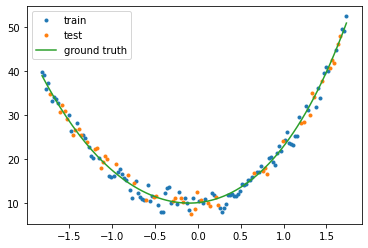

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data.reshape(-1, 1), y_data, test_size=.33, random_state=42)
# scaling the data is essential
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# visualizing train and test data
plt.plot(X_train, y_train, '.', label='train')
plt.plot(X_test, y_test, '.', label='test')

# visualizing the curve without noise
X_data = scaler.transform(X_data.reshape(-1, 1))
plt.plot(X_data, ground_truth, label='ground truth')
plt.legend(loc='best')
plt.show()

Задамо ваги та потрібні в навчанні змінні, які будуть оновлюватися під час роботи сесії.

Перезапускаючи код для пошуку кращої швидкості навчання, я реініціалізовувала граф. Значення моменту взяла 0.9, це дозволило зменшити кількість епох.

In [ ]:
tf.reset_default_graph()

n_epochs = 100
learn_rate = 0.01

theta_1 = tf.Variable(tf.random.uniform([1, 1], -1.0, 1.0))
theta_2 = tf.Variable(tf.random.uniform([1, 1], -1.0, 1.0))
theta_3 = tf.Variable(tf.random.uniform([1, 1], -1.0, 1.0))
theta_4 = tf.Variable(tf.random.uniform([1, 1], -1.0, 1.0))
theta_5 = tf.Variable(tf.random.uniform([1, 1], -1.0, 1.0), name = "bias")


X = tf.placeholder(tf.float32, shape=(None, 1), name='x_input')
y = tf.placeholder(tf.float32, shape=(None, 1), name='y_input')

y_pred = tf.matmul(tf.pow(X, 4), theta_1) + tf.matmul(tf.pow(X, 3), theta_2) \
      + tf.matmul(tf.pow(X, 2), theta_3) + tf.matmul(X, theta_4) + theta_5

error = y_pred - y
mse_cost = tf.reduce_mean(tf.square(error), name="mse")/2
optimizer = tf.train.MomentumOptimizer(learn_rate, momentum = 0.9).minimize(mse_cost)

init = tf.global_variables_initializer()

Збережемо модель під час навчання так, щоб потім можна було відновити контрольні точки. Реалізувати це можна завдяки recover_last_checkpoints().

In [ ]:
saver = tf.train.Saver()

In [ ]:
with tf.Session() as sess:
  sess.run(init)

  for e in range(n_epochs):
    if e % 10 == 0:
      print ("Epoch = ", e, "MSE = ", mse_cost.eval(feed_dict={X:X_train, y:y_train}))
      save_path = saver.save(sess, "/content/drive/My Drive/Colab Notebooks/Tf_polynomial/model_1.ckpt")
    sess.run(optimizer, feed_dict={X:X_train, y:y_train})

  save_path = saver.save(sess, "/content/drive/My Drive/Colab Notebooks/Tf_polynomial/model_1_final.ckpt")

  weights = sess.run([theta_5, theta_4, theta_3, theta_2, theta_1])

Epoch =  0 MSE =  300.20935
Epoch =  10 MSE =  66.53607
Epoch =  20 MSE =  6.543829
Epoch =  30 MSE =  6.337786
Epoch =  40 MSE =  5.171592
Epoch =  50 MSE =  2.5961764
Epoch =  60 MSE =  1.5776993
Epoch =  70 MSE =  1.3947387
Epoch =  80 MSE =  1.3533267
Epoch =  90 MSE =  1.3077642


Можемо побачити на побудованій лінії регресії, що модель гарно відтворює залежність між даними.

Scores on test data
RMSE: 1.630
R2 score: 0.978


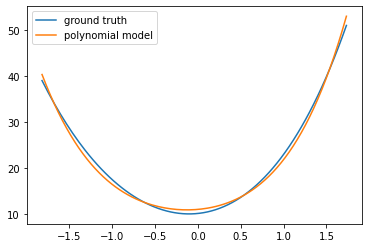

In [ ]:
pred = 0
pred_test = 0
for i in range(len(weights)):
  pred += weights[i] * np.power(X_data , i)
  pred_test += weights[i] * np.power(X_test, i)

print("Scores on test data")
metrics(y_test, pred_test)

plt.plot(X_data, ground_truth, label='ground truth')
plt.plot(X_data, pred, label='polynomial model')
plt.legend(loc='best')
plt.show()

Заресторимо модель, виведемо ваги, бачимо, що вони дійсно збереглися.

In [ ]:
with tf.Session() as sess:
  saver.restore(sess, "/content/drive/My Drive/Colab Notebooks/Tf_polynomial/model_1_final.ckpt")
  weights = sess.run([theta_5, theta_4, theta_3, theta_2, theta_1])

print(weights)

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Colab Notebooks/Tf_polynomial/model_1_final.ckpt
[array([[10.808176]], dtype=float32), array([[1.7738856]], dtype=float32), array([[6.946106]], dtype=float32), array([[0.9727047]], dtype=float32), array([[1.4334415]], dtype=float32)]


Датасет Бостон

In [ ]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :],     # even rows
                  raw_df.values[1::2, :2]])  # odd rows
target = raw_df.values[1::2, 2]
data.shape

(506, 13)

Усього датасет містить 13 атрибутів, числових або категоріальних. Цільова змінна - середня вартість будинків, в тис.$

Візуалізуємо точкові графіки, оберемо 4 атрибути.

Dependencies between price of homes (y-axis) and some attributes


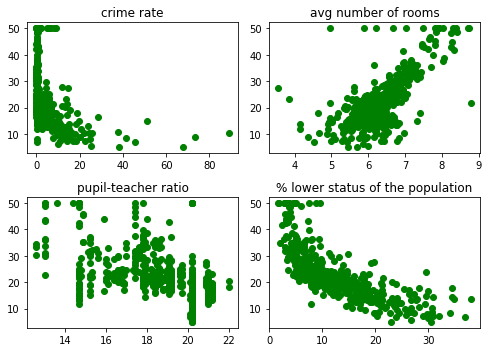

In [ ]:
title = ["crime rate", "avg number of rooms", "pupil-teacher ratio", "% lower status of the population"]

fig, ax = plt.subplots(2, 2)
fig.set_figheight(5)
fig.set_figwidth(7)

print("Dependencies between price of homes (y-axis) and some attributes")

for i,j in zip(range(4), [0, 5, 10, 12]):
    # subplots
    plt.subplot(2, 2, i+1) 
    plt.scatter(data[:, j], target, color='green')
    # the title to subplots
    plt.gca().set_title(title[i]) 
  
fig.tight_layout()
plt.show()

Розбиваємо дані на набори, центруємо+масштабуємо

In [ ]:
boston_train, boston_test, target_train, target_test = train_test_split(data, target.reshape(-1,1), test_size=.3, random_state=42)

scaler_b = StandardScaler()
boston_train = scaler_b.fit_transform(boston_train)
boston_test = scaler_b.transform(boston_test)

Налаштовано параметри learn_rate = 10**(-4), momentum = 0.99 та 3й степінь регресії, вони дали відносно найкращий результат в контексті поліноміальної регресії без регуляризації.

In [ ]:
tf.reset_default_graph()

n_epochs = 100000
learn_rate = 10**(-4)
n = boston_train.shape[0]

theta_1 = tf.Variable(tf.random.uniform([13, 1], -1.0, 1.0))
theta_2 = tf.Variable(tf.random.uniform([13, 1], -1.0, 1.0))
theta_3 = tf.Variable(tf.random.uniform([13, 1], -1.0, 1.0))
theta_b = tf.Variable(tf.random.uniform([1, 1], -1.0, 1.0), name = "bias")

X = tf.placeholder(tf.float32, shape=(None, 13), name='x_input')
y = tf.placeholder(tf.float32, shape=(None, 1), name='y_input')

y_pred = tf.matmul(tf.pow(X, 3), theta_3) + tf.matmul(tf.pow(X, 2), theta_2) \
      + tf.matmul(X, theta_1) + theta_b

error = y_pred - y
mse_cost = tf.reduce_mean(tf.square(error), name="mse")/2
optimizer = tf.train.MomentumOptimizer(learn_rate, momentum = 0.99).minimize(mse_cost)

init = tf.global_variables_initializer()

In [ ]:
with tf.Session() as sess:
  sess.run(init)

  for e in range(n_epochs):
    if e % 10000 == 0:
      print ("Epoch = ", e, "MSE = ", mse_cost.eval(feed_dict={X:boston_train, y:target_train}))
    sess.run(optimizer, feed_dict={X:boston_train, y:target_train})

  weights = sess.run([theta_b, theta_1, theta_2, theta_3])

Epoch =  0 MSE =  1444.9207
Epoch =  10000 MSE =  6.9328485
Epoch =  20000 MSE =  6.888411
Epoch =  30000 MSE =  6.8830485
Epoch =  40000 MSE =  6.8817267
Epoch =  50000 MSE =  6.8811355
Epoch =  60000 MSE =  6.8807654
Epoch =  70000 MSE =  6.880507
Epoch =  80000 MSE =  6.880325
Epoch =  90000 MSE =  6.8801937


Бачимо незначне перенавчання моделі, яке можна було б уникнути за допомогою регуляризації. Розсіювання спрогнозованих значень зображено га графіку.

Scores on train data
RMSE: 3.709
R2 score: 0.843
Scores on test data
RMSE: 3.606
R2 score: 0.826


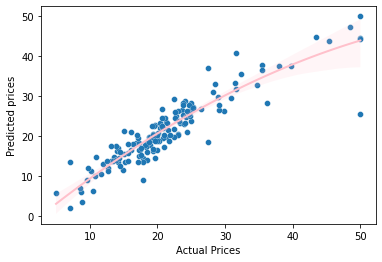

In [ ]:
pred_train = 0
pred_test = 0
for i in range(1,4):
  pred_train += np.power(boston_train , i) @ weights[i]
  pred_test += np.power(boston_test , i) @ weights[i]
pred_train += weights[0]
pred_test += weights[0]

print("Scores on train data")
metrics(target_train, pred_train)
print("Scores on test data")
metrics(target_test, pred_test)


sns.scatterplot(x = pd.Series(target_test.flat), y = pd.Series(pred_test.flat))
sns.regplot(x = target_test, y = pred_test, scatter_kws={'s': 20, 'alpha':0.3}, line_kws={'color':'pink', 'linewidth': 2}, order=2)
 
plt.xlabel("Actual Prices")
plt.ylabel("Predicted prices")
plt.show()